# Part 3 : Restoration

In this part of the TP, we are going to look at image restoration. We will look at several type of noise and ways to remove this noise. We first define some helper functions.

In [23]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color
from scipy.stats import bernoulli
is_colab = True

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return


--2021-11-28 19:43:16--  https://perso.telecom-paristech.fr/anewson/doc/images/palma.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 770583 (753K) [image/png]
Saving to: ‘palma.png.2’

palma.png.2         100%[===================>] 752.52K  1.28MB/s    in 0.6s    

2021-11-28 19:43:17 (1.28 MB/s) - ‘palma.png.2’ saved [770583/770583]



(600, 800)

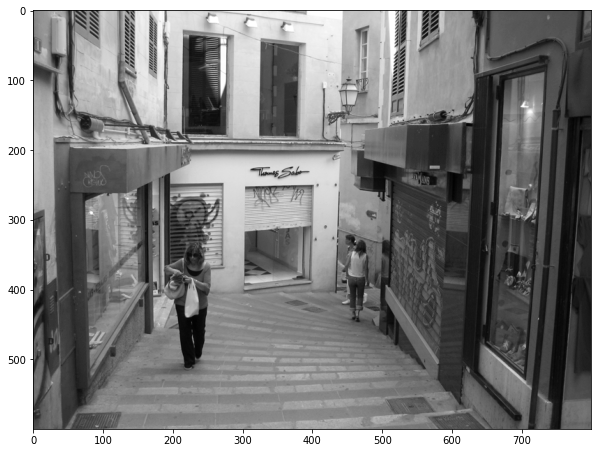

In [24]:
file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

We will look at the following noise types :

- Gaussian noise
- Impulse (salt-and-pepper) noise
- Missing pixels

Fill in the following functions to add this noise to a gray-level image. Do not forget to clip the pixe values to the range $(0,1)$.

In [25]:
def add_gaussian_noise(img_in,sigma_noise = 0.01):

    # FILL IN CODE
    img_out=img_in.copy()
    gauss=np.random.normal(0,sigma_noise,img_in.shape)
    img_out+=gauss
    return np.clip(img_out,0,1)

# we define the impulse probability p as the probability of a pixel not being affected
def add_impulse_noise(img_in,p=0.9):
    # FILL IN CODE
    img_out=img_in.copy()
    B=np.asarray(bernoulli.rvs(1-p, size=img_in.shape[0]*img_in.shape[1])).reshape(img_in.shape)
    img_out+=B
    return np.clip(img_out,0,1)

def add_missing_pixels_noise(img_in,p=0.9):
    # FILL IN CODE
    img_out=img_in.copy()
    B=np.asarray(bernoulli.rvs(p, size=img_in.shape[0]*img_in.shape[1])).reshape(img_in.shape)
    img_out*=B
    return img_out

Add the different noises to the input image, and display (or write) the results. Use the following parameters :

- sigma_noise=0.05 for the gaussian noise
- $p=0.9$ (the probability of a pixel __not__ being affected, for the impulse noise and missing pixels

In [4]:
sigma_noise = 0.05
img_gray_gaussian = add_gaussian_noise(img_gray, sigma_noise)
write_image(img_gray_gaussian,file_name+'_gaussian_noise.png')

img_gray_impulse = add_impulse_noise(img_gray, 0.9)
write_image(img_gray_impulse,file_name+'_impulse_noise.png')

img_gray_missing = add_missing_pixels_noise(img_gray, 0.9)
write_image(img_gray_missing,file_name+'_missing_pixels.png')

__Question 3.1__ For each type of noise, propose a restoration filter (see course slides) 

__Answer__ For the different types of noise, we propose the following filters:

-Smoothing filter: for Gaussian noise.

-Median filter: for Impulse noise and missing pixels.

Implement these restoration techniques in appropriately named functions, and write the corresponding output images. Try to find the parameters which give the best results (visually).

__Note__, you can use the filtering functions of the ``scipy.ndimage`` package, where the filtering is already implemented

In [26]:
from scipy import ndimage

def gaussian_filter(img,sigma = 3):
  #INSERT CODE HERE
  return(ndimage.gaussian_filter(img,sigma))


def median_filter(img,median_size):
  #INSERT CODE HERE
  return(ndimage.median_filter(img,size=median_size))

sigma_gauss = 1.0
img_out_gaussian = gaussian_filter(img_gray_gaussian,sigma_gauss)
write_image(img_out_gaussian,file_name+'_denoised_gaussian.png')

median_size = 3
img_out_impulse_median = median_filter(img_gray_impulse,median_size)
write_image(img_out_impulse_median,file_name+'_impulse_denoised_median.png')

img_out_missing_median = median_filter(img_gray_missing,median_size)
write_image(img_out_missing_median,file_name+'_missing_denoised_median.png')

__Question 3.2__ Roughly speaking, what is the tradeoff which you are trying to achieve by tuning the parameters ?

__Answer__ By tuning the parameters we are trying to compromise two things. The first one is how muuch we denoise the image and the other one is the quality of the image. We want to have a good denoising of the image without reducing its quality.

### Evaluation

A commonly used metric for denoising is the ''Peak Signal-to-Noise Ratio'' (PSNR). This is linked to the commonly known mean squared error. The mean squared error is defined, for a reference image $Y$ and a restored image $Y$, of size $m \times n$ as :

- MSE$(Y,I) = \frac{1}{mn} \sum_{x,y} \left( I_{x,y} - Y_{x,y}\right)^2 $

The PSNR is defined, in Decibels, as :

PSNR$(Y,I) = 10 * \log{\left( \frac{I_{max}^2}{MSE(Y,I)} \right)}$,

where $I_{max}$ is the maximum value of the image. For us (normalised to 1), this gives :

PSNR$(Y,I) = -10 * \log{ \left({MSE(Y,I)} \right)}$.

Implement this in a function, and create a code to plot the PSNR for several values of the paramter, __in the Gaussian case only__. 

Text(0.5, 0, 'PSNR')

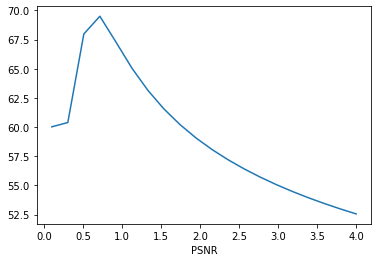

In [27]:
def PSNR(img,img_ref):
    #INSERT CODE HERE
    mse=((img-img_ref)**2).mean()
    psnr=-10*np.log(mse)
    return psnr

#INSERT CODE HERE
sigma=np.linspace(0.1,4,20)
S=[PSNR(ndimage.gaussian_filter(img_gray_gaussian,s),img_gray) for s in sigma]
plt.plot(sigma,S)
plt.xlabel("sigma")
plt.xlabel("PSNR")

## Deconvolution

In this part of the TP, we are going to try and invert a convolution operation. This is called __deconvolution__, and can be carried out in the Fourier domain, as follows. For an image $I$, filter $f$ and an output $Y$, if we have :

$Y = I \ast f$,

then using the convolution theorem (see lesson), we have :

$I = \text{IFFT}\left(\frac{\hat{Y}}{\hat{f}}\right)$

where $\hat{Y}$ and $\hat{f}$ are the Fourier transforms of $Y$ and $f$ respectively.

To simplify the problem, we take a square image for this part of the TP.


--2021-11-28 19:43:34--  https://perso.telecom-paristech.fr/anewson/doc/images/boston.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626414 (612K) [image/png]
Saving to: ‘boston.png’

boston.png          100%[===================>] 611.73K  1.03MB/s    in 0.6s    

2021-11-28 19:43:35 (1.03 MB/s) - ‘boston.png’ saved [626414/626414]



(600, 600)

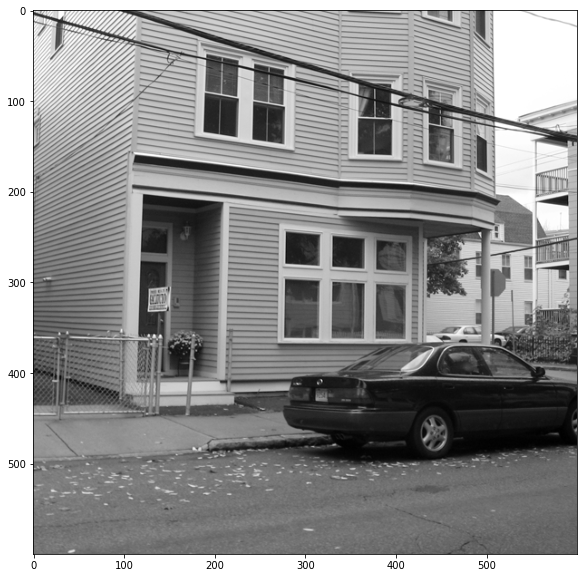

In [28]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)
img_gray.shape

Now, let us consider the following fiter, defined in the Fourier domain :

(600, 600)


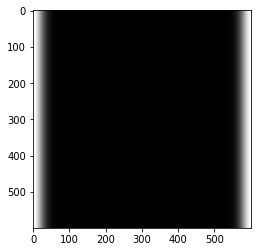

In [29]:
from scipy import signal

img_size = img_gray.shape[0]
h_size = int(np.floor(img_size/2.0))
f_hat = np.zeros((img_size,img_size))

X = np.asarray(range(-h_size,h_size))
f_hat = np.tile( np.expand_dims( np.exp(-( X**2) / (2.0*(20.0**2))) , axis=1), (1,img_size)).T
f_hat /= f_hat.sum()
f_hat = np.fft.ifftshift(f_hat)
plt.imshow( np.log( np.abs(f_hat)+1), cmap = 'gray')

print(f_hat.shape)

Using the convolution theorem and the inverse Fourier transform, carry out the convolution of the input image with $f$ and write the result ``img_convolved`` to an output file


In [36]:
#INSERT CODE HERE

Y_hat=np.fft.fft2(img_gray)*f_hat
img_convolved=np.fft.ifft2(Y_hat)
img_convolved = (img_convolved-np.min(img_convolved))/(np.max(img_convolved)-np.min(img_convolved))
write_image(img_convolved,file_name+'_convolved_image.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


__Question 3.3__ What does this filter do (you can use the visualisation method from the first part of the TP to see what the filter spectrum looks like) ? How can this happen in real life ? 

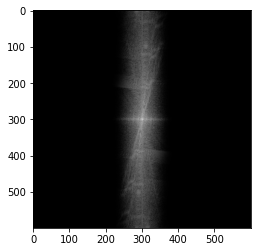

In [38]:
def display_spectrum(img):
    #INSERT CODE HERE
    spec_mag=np.abs(np.fft.fftshift(np.fft.fft2(img)))
    return plt.imshow(np.log(spec_mag+1),cmap='gray')

display_spectrum(img_convolved)

__Answer__ By visualizing the spectrum of the convolved image, we see that only frequencies lying on the vertical edge are preserved in the signal. This means that the variability of the image is vertical. We can see this in the convolved image that seems to have vertical bluring. In real life this may happen due to instability of the camera that tends to have vertical movement. (The same problem may occur in the horizontal case).

Now, create a function which carries out a deconvolution in the Fourier domain, given an image and the Fourier transform of the filter $\hat{f}$. You can reuse the code in the first part of the TP. Carry out the deconvolution on ``img_convolved`` and write the result to an output file. Remember to renormalise the output image.

__Important note__ : You will have a problem with very small values of $\hat{f}$ (division by 0). Propose a simple method to address this issue (look at the formula at the beginning of this section on deconvolution).


In [42]:
def deconvolve_fourier(img,f_hat):
    #INSERT CODE HERE
    epsilon=1e-16
    Y_hat = np.fft.fft2(img)
    img_out = np.fft.ifft2(Y_hat/(f_hat+epsilon))
    return img_out

img_out = np.real(deconvolve_fourier(img_convolved,f_hat))
img_out -= img_out.min()
img_out /= img_out.max()


write_image(img_out,file_name+'_deconvolved.png')